In [1]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *


plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : $\beta$ accross all layers (Top-10% filters)

In [2]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [3]:
k = 10 # Top 10% highest l2-magnitude filters

In [17]:
conv_layers = []
for l in model.layers:
    if 'conv2d' in str(type(l)).lower():
        conv_layers.append(l)

mixed = []
sym  =  []   #beta < .25
anti =  []  #beta > .75

for l_num, l in enumerate(conv_layers):
    anti.append(0)
    sym.append(0)
    mixed.append(0)
    count = 0
    print(f" ============ LAYER {l_num} ==================")
    top10F=topKfilters(model, l_num, k=k)
    beta_f = []
    for f in top10F:
        top10C = topKchannels(model, l_num, f, k=k)

        filters = tf.expand_dims(get_filter(model, l_num)[:,:,top10C, f], -1)
        s, a = getSymAntiSymTF(filters)
        a_energy = reduce_euclidean_norm(a, axis=[0,1])**2
        s_energy = reduce_euclidean_norm(s, axis=[0,1])**2
        total_energy  = reduce_euclidean_norm(filters, axis=[0,1])**2
        beta = a_energy/total_energy

        for b in beta:
            print(b)
            if b>=0.75:
               anti[-1]+=1
            elif b<=0.25:
               sym[-1]+=1
            else:
               mixed[-1]+=1
            count+=1

    anti[-1] = anti[-1]/count
    sym[-1] = sym[-1]/count
    mixed[-1] = mixed[-1]/count

    print(anti, sym, mixed)
    print(beta.shape[0])




 ============ LAYER 0 ==================
tf.Tensor([0.61684614], shape=(1,), dtype=float32)
tf.Tensor([0.69619465], shape=(1,), dtype=float32)
tf.Tensor([0.6776463], shape=(1,), dtype=float32)
tf.Tensor([0.88876224], shape=(1,), dtype=float32)
tf.Tensor([0.9215914], shape=(1,), dtype=float32)
tf.Tensor([0.91603833], shape=(1,), dtype=float32)
tf.Tensor([0.8956371], shape=(1,), dtype=float32)
tf.Tensor([0.9203072], shape=(1,), dtype=float32)
tf.Tensor([0.91718763], shape=(1,), dtype=float32)
tf.Tensor([0.9973122], shape=(1,), dtype=float32)
tf.Tensor([0.9974147], shape=(1,), dtype=float32)
tf.Tensor([0.99621105], shape=(1,), dtype=float32)
tf.Tensor([0.9998107], shape=(1,), dtype=float32)
tf.Tensor([0.99968517], shape=(1,), dtype=float32)
tf.Tensor([0.9996667], shape=(1,), dtype=float32)
tf.Tensor([0.8431785], shape=(1,), dtype=float32)
tf.Tensor([0.8837658], shape=(1,), dtype=float32)
tf.Tensor([0.87746453], shape=(1,), dtype=float32)
[0.8333333333333334] [0.0] [0.16666666666666666]
3


In [18]:
anti

[0.8333333333333334,
 0.4166666666666667,
 0.8333333333333334,
 0.5138888888888888,
 0.29333333333333333,
 0.3264,
 0.3392,
 0.27137254901960783,
 0.36947327950788156,
 0.24067666282199154,
 0.24067666282199154,
 0.18262206843521722,
 0.020376778162245292]

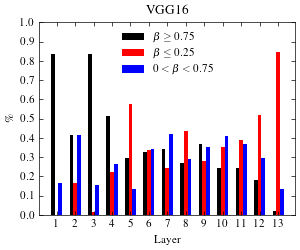

In [33]:
x = np.arange(1, len(conv_layers)+1, step=1)
width = 0.2

plt.bar(x-0.2, anti, width) 
plt.bar(x, sym, width ) 
plt.bar(x+0.2, mixed, width) 
#plt.xticks(x, [']) 
plt.xlabel("Layer") 
plt.ylabel("\%") 
plt.xticks(x)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.title('VGG16')

plt.minorticks_off()
plt.legend([r"$\beta\geq0.75$", r"$\beta\leq0.25$", r"$0<\beta<0.75$"]) 
plt.savefig('figures/vgg16_kernel_type.png', dpi=600)

plt.show() 